# Poisson Equation
We consider the two dimensional Poisson equation for two PINNs as in https://arxiv.org/pdf/2109.09444.pdf.
$$
\begin{cases}
    u_{xx} + u_{yy} = f \text{ for } (x,y)\in [0,1]\times [0,1] \\
    u(0, y) = u(1, y) = u(x, 0) = u(x, 1)= 0 \\
\end{cases}
$$

In this case, we consider:
$$
\begin{cases}
    f = 1 \text{ for }(x,y)\in [0.25,0.75] \times [0.25,0.75]\\
    f = 0 \text{    else}
\end{cases}
$$

In [1]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp

from jax import config

config.update("jax_enable_x64", True)

## Initializing the PINN

In [2]:
from utils import data_path

file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh
xpinn = XPINN(file, activation)

PINN number 0 initializing
PINN number 1 initializing


We visualize the points of the domain decomposition.

(281, 2)
(40, 2)
(119, 2)
(40, 2)


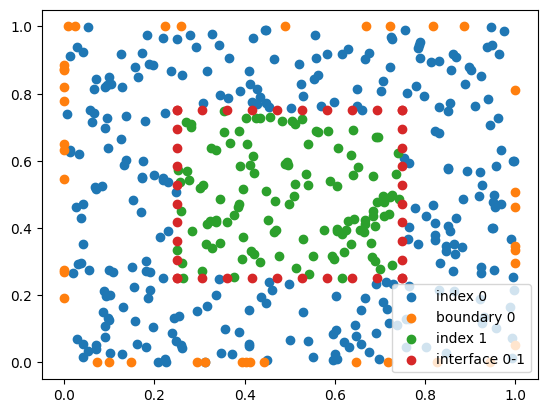

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    print(pinn.interior.shape)
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    if pinn.boundary.size != 0:
        print(pinn.boundary.shape)
        plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    print(p.shape)
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

### PINN Formalization
We only consider boundary loss for the outer PINN.

### Setting the loss function
We create a base function for initializing the boundary loss functions, which is relatively simple in this case. 

In [4]:
from typing import Callable
from type_util import Params
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


def boundary_loss_factory(target: float | Array) -> LFunc:
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["boundary"]
        eval = v_model(params, pts)
        return np.mean((eval - target) ** 2)

    return boundary_loss

In [5]:
def interior_loss_factory(index: int, rhs: float) -> LFunc:

    def hess(params):
        return hessian(lambda x: model(params, x))

    def residual(params, x):
        return np.trace(hess(params)(x)[0]) - rhs

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts) ** 2)

    return interior_loss

Setting the boundary and interior loss

In [6]:
p0, p1 = xpinn.PINNs

p0.boundary_loss = boundary_loss_factory(0.0)

p0.interior_loss = interior_loss_factory(0, 0.0)  # implementing rhs
p1.interior_loss = interior_loss_factory(1, 1.0)

Setting the interface loss

In [7]:
def interface_loss_factory(i: int, j: int) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return 80 * (res_ij + avg_ij)

    return interface_loss

In [8]:
p0.interface_loss = interface_loss_factory(0, 1)
p1.interface_loss = interface_loss_factory(1, 0)

In [9]:
shapes = [[2] + [20] * 9 + [1]] * 2
optimizer = optax.adam(learning_rate=0.0001)
xpinn.initialize_params(shapes, optimizer)

In [10]:
n_iter = 20000
losses = xpinn.run_iters(n_iter)

121.29318334451598
121.29318334451598
0.00% iter = 0 of 20000: Total loss = 243.87499509052054
118.39009832056786
118.39009832056786
115.55464117643409
115.55464117643409
112.78629135185395
112.78629135185395
110.08432084617809
110.08432084617809
107.44758823821577
107.44758823821577
104.87467030357732
104.87467030357732
102.36397000790663
102.36397000790663
99.91372650143265
99.91372650143265
97.52202576965588
97.52202576965588
95.18684513893484
95.18684513893484
92.90610442907877
92.90610442907877
90.67770081293301
90.67770081293301
88.4995274297546
88.4995274297546
86.3694843743503
86.3694843743503
84.28548778474423
84.28548778474423
82.2454788511038
82.2454788511038
80.24743305785242
80.24743305785242
78.28936958139023
78.28936958139023
76.36936046781942
76.36936046781942
74.48553910943038
74.48553910943038
72.63610728833464
72.63610728833464
70.81934034804141
70.81934034804141
69.03359080949733
69.03359080949733
67.27729092438469
67.27729092438469
65.54895449547519
65.548954495475

Text(0.5, 1.0, 'Loss per Pinn over 20000 epochs')

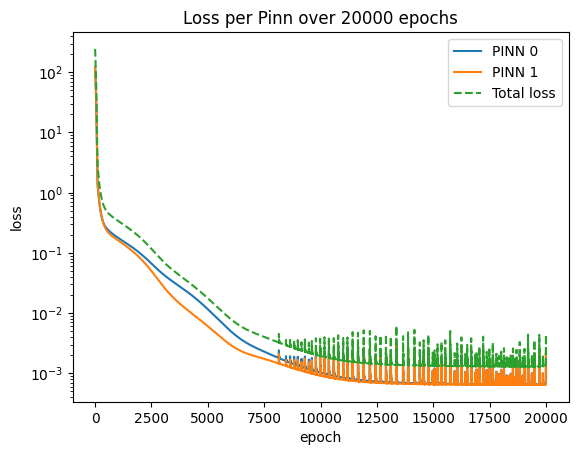

In [11]:
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [12]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

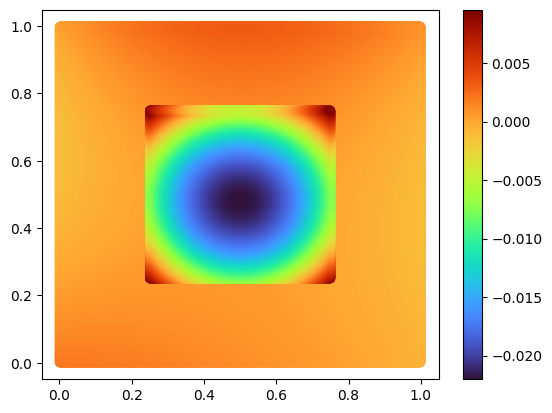

In [13]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    plt.clim(min_, max_)

plt.colorbar()

In [14]:
p1 = xpinn.PINNs[1]
p1.loss(p1.params, xpinn.main_args[1])

Array(0.00065047, dtype=float64)

In [15]:
p0 = xpinn.PINNs[0]
p0.loss(p0.params, xpinn.main_args[0])

Array(0.00080518, dtype=float64)

In [16]:
p0.interface_loss(p0.params, xpinn.main_args[0])

Array(0.00079361, dtype=float64)

In [17]:
p0.boundary_loss(p0.params, xpinn.main_args[0])

Array(2.14037079e-06, dtype=float64)

In [18]:
p0.interior_loss(p0.params, xpinn.main_args[0])

Array(9.43428237e-06, dtype=float64)

In [19]:
p0.v_residual(p0.params, xpinn.main_args[0]["interior"])

Array([ 1.02447000e-03, -3.40535193e-03,  2.42819588e-03,  1.82360341e-03,
        3.87563060e-03, -4.18332992e-03, -5.85279201e-03,  5.32255004e-04,
        5.06287450e-03,  5.92229466e-03,  2.22538068e-03, -1.62219661e-03,
        3.69224340e-03, -8.61675145e-04, -2.11957952e-03, -8.09342390e-03,
       -4.68154031e-03, -6.05864564e-03, -1.78036198e-03,  1.74733143e-03,
        3.13661278e-04, -3.81142846e-03, -1.29189013e-03,  8.94444906e-04,
       -1.36032649e-03, -7.32592964e-04,  1.97802095e-03,  3.14612280e-03,
       -2.08099341e-03, -4.31093079e-04,  2.63720685e-03, -8.03846292e-03,
        2.63717632e-03,  1.56938189e-03,  5.57770689e-03, -2.88018128e-03,
        5.09264775e-03,  1.79227086e-03, -1.99999615e-03,  3.50529689e-03,
       -5.14880498e-04,  3.39875727e-03, -2.29436486e-03,  9.56793169e-04,
       -1.02472438e-03, -2.00046123e-03, -4.78061526e-03,  2.38063384e-03,
       -1.89939340e-03,  1.52077586e-03,  1.96971812e-03,  3.15660246e-03,
       -6.18637915e-04,  

In [20]:
p1.v_residual(p1.params, xpinn.main_args[1]["interior"]).shape

(119,)

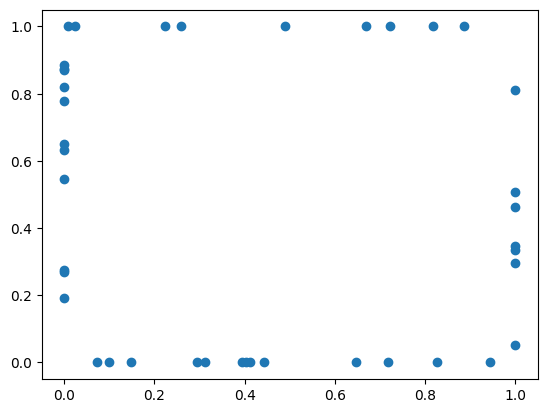

In [21]:
plt.plot(
    xpinn.main_args[0]["boundary"][:,
                                   0], xpinn.main_args[0]["boundary"][:, 1], "o"
)

In [22]:
rhs = 0.0


def hess(params):
    return hessian(lambda x: model(params, x))


def residual(params, x):
    return np.trace(hess(params)(x)[0]) - rhs

In [23]:
x = xpinn.main_args[0]["interior"][0]
np.trace(hess(p0.params)(x))

Array([-0.01647448, -0.00367512], dtype=float64)

In [24]:
hess(p0.params)(x)[0]

Array([[-0.01647448, -0.00367512],
       [-0.00367512,  0.01749895]], dtype=float64)